# An introductional notebook to HEP analysis in C++

<p>In this notebook you can find an easy set of commands that show some basic computing techniques commonly used in High Energy Physics (HEP) analyzes.</p>

<p>It also shows how to create an histogram, fill it and draw it. Moreover it is an introduction to [ROOT](https://root.cern.ch/) too. The final output is a plot with the number of leptons.</p>

Based on ATLAS opendata notebooks (http://opendata.atlas.cern/release/2020/documentation/notebooks/intro.html)


The library used is [ROOT](https://root.cern.ch/), a scientific data analysis software framework that provides a large set of functionalities needed to deal with big data processing, statistical analysis, visualisation and storage.

<p>At first we have to include several helpers that will support our analysis:</p>

In [1]:
#include <iostream>
#include <string>
#include <stdio.h>

Next we have to open the data that we want to analyze. As described above the data is stored in a _*.root_ file. This is a root file containing tracks and calorimeter clusters

In [2]:
TFile *file = TFile::Open("Data_8TeV.root"); 

The next step is to define a tree named _tree_ to get the data out of the _*.root_ file. The tree in this root file is called "JetRecoTree". We will then print the contents of the tree to find the names of the variables. 

In [3]:
TTree *tree = (TTree*) file->Get("mini");
tree->Print()

******************************************************************************
*Tree    :mini      : 4-vectors + variables required for scaling factors     *
*Entries : 14945674 : Total =      3737586466 bytes  File  Size = 1366006484 *
*        :          : Tree compression factor =   2.74                       *
******************************************************************************
*Br    0 :runNumber : runNumber/I                                            *
*Entries : 14945674 : Total  Size=   59789737 bytes  File Size  =     297928 *
*Baskets :       70 : Basket Size=    1224192 bytes  Compression= 200.68     *
*............................................................................*
*Br    1 :eventNumber : eventNumber/I                                        *
*Entries : 14945674 : Total  Size=   59789885 bytes  File Size  =   44412272 *
*Baskets :       70 : Basket Size=    1224192 bytes  Compression=   1.35     *
*...................................................

Activate variables 

In [4]:

Bool_t e_trig;
Bool_t mu_trig;
Bool_t good_vtx;
UInt_t lep_n;
UInt_t jet_n;
Float_t MET;
Float_t MET_phi;

Float_t lep_pt[10];  
Float_t lep_eta[10];  
Float_t lep_phi[10];  
Float_t lep_E[10];  
Int_t lep_type[10];  
Float_t lep_ptcone30[10];
Float_t lep_etcone20[10];

Float_t jet_pt[10];  
Float_t jet_jvf[10];
Float_t jet_MV1[10];
Float_t jet_eta[10];

tree->SetBranchAddress("trigE", &e_trig);
tree->SetBranchAddress("trigM", &mu_trig);
tree->SetBranchAddress("hasGoodVertex", &good_vtx);
tree->SetBranchAddress("lep_n", &lep_n);
tree->SetBranchAddress("jet_n", &jet_n);
tree->SetBranchAddress("met_et", &MET);
tree->SetBranchAddress("met_phi", &MET_phi);

tree->SetBranchAddress("lep_pt", &lep_pt);
tree->SetBranchAddress("lep_eta", &lep_eta);
tree->SetBranchAddress("lep_phi", &lep_phi);
tree->SetBranchAddress("lep_E", &lep_E);
tree->SetBranchAddress("lep_type", &lep_type);
tree->SetBranchAddress("lep_ptcone30", &lep_ptcone30);
tree->SetBranchAddress("lep_etcone20", &lep_etcone20);

tree->SetBranchAddress("jet_pt", &jet_pt);
tree->SetBranchAddress("jet_eta", &jet_eta);
tree->SetBranchAddress("jet_jvf",&jet_jvf);
tree->SetBranchAddress("jet_MV1",&jet_MV1);



Create Canvas

In [5]:
TCanvas *canvas = new TCanvas("Canvas","",800,600);

Create histograms: Leading jet pT and all jets pT 

In [6]:
TH1F *cutflow = new TH1F("Cutflow","Cutflow; Cut; Events",10,0,10);

TH1F *hist_njets = new TH1F("Number of jets","n-jets; Jet multiplicity; Events",10,0,10);

TH1F *hist_lep_pt = new TH1F("Leptons_pt","Lepton_pt; Lep_pt; Events",10,0,630000);
TH1F *hist_lep_ptcone30 = new TH1F("Leptons_ptcone30","Lepton ptcone30; Lep_ptcone30; Events",10,0,40);
TH1F *hist_lep_etcone20 = new TH1F("Leptons_etcone20","Lepton etcone20; Lep_etcone20; Events",10,-3000,40000);
TH1F *hist_lep_eta = new TH1F("Leptons_eta","Lepton eta; Lep_eta; Events",10,-4,4);
TH1F *hist_jets_pt = new TH1F("Jets_pt","Jets pt; Jets_pt; Events",10,0,230000);
TH1F *hist_jets_eta = new TH1F("Jets_eta","Jets_eta; Jets_eta; Events",10,-4,4);
TH1F *hist_jets_JVF = new TH1F("Jets_JVF","Jets_JVF; Jets JVF; Events",25,0,1.4);
TH1F *hist_jets_MV1 = new TH1F("Jets_MV1","Jets_MV1; Jets MV1; Events",10,0,1.1);
TH1F *hist_bjets_n = new TH1F("b-jets_n","b-jets_number;b-jets number; Events",20,0,10);
TH1F *hist_MET = new TH1F("MET","MET; MET; Events",20,0,600000);
TH1F *hist_MTW = new TH1F("MTW","MTW; MTW; Events",20,0,200000);

In [7]:
//Understanding Vertex Cut (cut1)
for (int k = 18; k < 21; k++)
{
    tree->GetEntry(k);
    if (!good_vtx) {
        std::cout<<"Entry number "<< k << " Good Vertex Negacion del bueno" << !good_vtx << '\t' << good_vtx <<'\n';
    }
    else {
        std::cout<<"Entry number "<< k << " Bad Vertex " << !good_vtx <<'\t' << good_vtx <<'\n';
    }
}

Entry number 18 Bad Vertex 0	1
Entry number 19 Good Vertex Negacion del bueno1	0
Entry number 20 Bad Vertex 0	1


Loop and fill histograms

In [8]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

/* for printing purposes we change int by double 
int cut1 = 0.;
int cut2 = 0;
int cut3 = 0;
int cut4 = 0;
int cut5 = 0;
int cut6 = 0;
int cut7 = 0;
int cut8 = 0;
*/ 

double cut1 = 0.;
double cut2 = 0.;
double cut3 = 0.;
double cut4 = 0.;
double cut5 = 0.;
double cut6 = 0.;
double cut7 = 0.;
double cut8 = 0.;

for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i);   

    //First cut: Good vertex
    if(!good_vtx) continue;
    cut1++;
    cutflow->Fill(1);

    //Second cut: Trigger
    if(!e_trig && !mu_trig) continue;
    cut2++;
    cutflow->Fill(2);
    
    for(unsigned int i=0; i<lep_n; i++){
        hist_lep_pt->Fill(lep_pt[i]);
        hist_lep_ptcone30->Fill(lep_ptcone30[i]/lep_pt[i]);
        hist_lep_etcone20->Fill(lep_etcone20[i]/lep_pt[i]);
        hist_lep_eta->Fill(lep_eta[i]);
    }
    // Preselection of good leptons                                                                                
    int n_mu=0;
    int n_el=0;
    int n_lep=0;
    int good_lep=0;
    //Loop over leptons
    for(unsigned int i=0; i<lep_n; i++){
        if( lep_pt[i] < 25000.) continue; 
        if( lep_ptcone30[i]/lep_pt[i] > 0.15 ) continue; 
        if( lep_etcone20[i]/lep_pt[i] > 0.15 ) continue;  
        if( lep_type [i]==13 && TMath::Abs(lep_eta[i]) < 2.5 ){
            n_mu++;
             //AÑADIDO    
        }
        /*
        To complete: Add electrons and extract the index for the good lepton
        */
        if( lep_type [i]==11 && TMath::Abs(lep_eta[i]) < 2.47 ){
            if(TMath::Abs(lep_eta[i]) < 1.37 || TMath::Abs(lep_eta[i]) > 1.52){
                n_el++;
                good_lep=i;}
        }
    }
    //Select events with only 1 good lepton and fill the cutflow histogram 
    //Example:
    //Third cut (one good lepton):
    n_lep=n_el+n_mu;
    if(n_lep!=1) continue;
    cutflow->Fill(3); 
    cut3++;
  
    
    int n_jets=0;
    int n_bjets=0;
    
    //Number of jets distribution
    hist_njets->Fill(jet_n);

    //Fourth cut: At least 4 jets
    if(jet_n<4) continue; 
    cutflow->Fill(4); 
    cut4++;
    
    for(unsigned int k=0; k<jet_n; k++){
        hist_jets_pt->Fill(jet_pt[k]);
        hist_jets_eta->Fill(jet_eta[k]);
        hist_jets_JVF->Fill(jet_jvf[k]);
        hist_jets_MV1->Fill(jet_MV1[k]);
    }
    for(unsigned int j=0; j<jet_n; j++){
        // To complete: apply jet cuts to find the good jets
        if(jet_pt[j] < 25000.) continue;
        //Eta cut
        if(TMath::Abs(jet_eta[j])>2.5) continue;//Discrepancia, preguntar por que funciona con >
        // JVF cleaning 
        if(jet_jvf[j]<0.5 && TMath::Abs(jet_eta[j])< 2.4 && jet_pt[j]<50000.) continue;
        n_jets++;
        // cut on 0.7892 MV1 and count the number of b-jets
        if(jet_MV1[j]<0.7892) continue; // Las diapos dicen que debe ser >=
        n_bjets++;
        }
    
    //Fifth cut: At least 4 good jets
    if(n_jets<4) continue; 
    cutflow->Fill(5); 
    cut5++;
    
    hist_bjets_n->Fill(n_bjets);
    //Sixth cut: at least one b-jet
    if(n_bjets < 1) continue;
    cutflow->Fill(6);
    cut6++;
    
    hist_MET->Fill(MET);
    //Seventh cut: MET > 30 GeV
    if(MET < 30000.) continue;// Ponemos el MET > a 30000
    cutflow->Fill(7);
    cut7++;
    // TLorentzVector definitions                                                               
    TLorentzVector Lepton  = TLorentzVector();
    TLorentzVector  MeT  = TLorentzVector();

    //To complete: Lorentz vectors for the lepton and MET. Use SetPtEtaPhiE().
    Lepton.SetPtEtaPhiE(lep_pt[good_lep],lep_eta[good_lep],lep_phi[good_lep],lep_E[good_lep]);
    MeT.SetPtEtaPhiE(MET,0,MET_phi,MET); 
    //Calculation of the mTW using TLorentz vectors             
    float mTW = sqrt(2*Lepton.Pt()*MeT.Et()*(1-cos(Lepton.DeltaPhi(MeT))));

    hist_MTW->Fill(mTW);
    //Eight cut: mTW > 30 GeV
    if(mTW<30000.) continue;
    cutflow->Fill(8);    
    cut8++;
    
    //We fill all histograms
    /*
    for(unsigned int i=0; i<lep_n; i++){
        hist_lep_pt->Fill(lep_pt[i]);
        hist_lep_ptcone30->Fill(lep_ptcone30[i]/lep_pt[i]);
        hist_lep_etcone20->Fill(lep_etcone20[i]/lep_pt[i]);
        hist_lep_eta->Fill(lep_eta[i]);
    }
    */
    /*
    for(unsigned int k=0; k<jet_n; k++){
        hist_jets_pt->Fill(jet_pt[k]);
        hist_jets_eta->Fill(jet_eta[k]);
        hist_jets_JVF->Fill(jet_jvf[k]);
        hist_jets_MV1->Fill(jet_MV1[k]);
    }
    */
    //hist_bjets_n->Fill(n_bjets);
    //hist_MTW->Fill(mTW);
    //hist_MET->Fill(MET);
}

std::cout << "Done!" << std::endl;
std::cout << "All events:" << nentries << std::endl;
std::cout << "Cut1:" << cut1 << std::endl;
std::cout << "Cut2:" << cut2 << std::endl;
std::cout << "Cut3:" << cut3 << std::endl;
std::cout << "Cut4:" << cut4 << std::endl;
std::cout << "Cut5:" << cut5 << std::endl;
std::cout << "Cut6:" << cut6 << std::endl;
std::cout << "Cut7:" << cut7 << std::endl;
std::cout << "Cut8:" << cut8 << std::endl;

//Absolute event selection efficiency for all cuts
double epsilon_abs_cut1 = cut1/nentries;
double epsilon_abs_cut2 = cut2/nentries;
double epsilon_abs_cut3 = cut3/nentries;
double epsilon_abs_cut4 = cut4/nentries;
double epsilon_abs_cut5 = cut5/nentries;
double epsilon_abs_cut6 = cut6/nentries;
double epsilon_abs_cut7 = cut7/nentries;
double epsilon_abs_cut8 = cut8/nentries;

std::cout<< "Absolute event selection efficiency for Cut 1 is: "<< epsilon_abs_cut1 << '\n';
std::cout<< "Absolute event selection efficiency for Cut 2 is: "<< epsilon_abs_cut2 << '\n';
std::cout<< "Absolute event selection efficiency for Cut 3 is: "<< epsilon_abs_cut3 << '\n';
std::cout<< "Absolute event selection efficiency for Cut 4 is: "<< epsilon_abs_cut4 << '\n';
std::cout<< "Absolute event selection efficiency for Cut 5 is: "<< epsilon_abs_cut5 << '\n';
std::cout<< "Absolute event selection efficiency for Cut 6 is: "<< epsilon_abs_cut6 << '\n';
std::cout<< "Absolute event selection efficiency for Cut 7 is: "<< epsilon_abs_cut7 << '\n';
std::cout<< "Absolute event selection efficiency for Cut 8 is: "<< epsilon_abs_cut8 << '\n';

//Relative event selection efficiency for all cuts
double epsilon_rel_cut1 = cut1/cut1;
double epsilon_rel_cut2 = cut2/cut1;
double epsilon_rel_cut3 = cut3/cut2;
double epsilon_rel_cut4 = cut4/cut3;
double epsilon_rel_cut5 = cut5/cut4;
double epsilon_rel_cut6 = cut6/cut5;
double epsilon_rel_cut7 = cut7/cut6;
double epsilon_rel_cut8 = cut8/cut7;

std::cout<< "Relative event selection efficiency for Cut 1 is: "<< epsilon_rel_cut1 << '\n';
std::cout<< "Relative event selection efficiency for Cut 2 is: "<< epsilon_rel_cut2 << '\n';
std::cout<< "Relative event selection efficiency for Cut 3 is: "<< epsilon_rel_cut3 << '\n';
std::cout<< "Relative event selection efficiency for Cut 4 is: "<< epsilon_rel_cut4 << '\n';
std::cout<< "Relative event selection efficiency for Cut 5 is: "<< epsilon_rel_cut5 << '\n';
std::cout<< "Relative event selection efficiency for Cut 6 is: "<< epsilon_rel_cut6 << '\n';
std::cout<< "Relative event selection efficiency for Cut 7 is: "<< epsilon_rel_cut7 << '\n';
std::cout<< "Relative event selection efficiency for Cut 8 is: "<< epsilon_rel_cut8 << '\n';

//Binomial errors
double deltaepsilon_abs_cut1 = sqrt((epsilon_abs_cut1*(1 - epsilon_abs_cut1))/nentries);
double deltaepsilon_abs_cut2 = sqrt((epsilon_abs_cut2*(1 - epsilon_abs_cut2))/nentries);
double deltaepsilon_abs_cut3 = sqrt((epsilon_abs_cut3*(1 - epsilon_abs_cut3))/nentries);
double deltaepsilon_abs_cut4 = sqrt((epsilon_abs_cut4*(1 - epsilon_abs_cut4))/nentries);
double deltaepsilon_abs_cut5 = sqrt((epsilon_abs_cut5*(1 - epsilon_abs_cut5))/nentries);
double deltaepsilon_abs_cut6 = sqrt((epsilon_abs_cut6*(1 - epsilon_abs_cut6))/nentries);
double deltaepsilon_abs_cut7 = sqrt((epsilon_abs_cut7*(1 - epsilon_abs_cut7))/nentries);
double deltaepsilon_abs_cut8 = sqrt((epsilon_abs_cut8*(1 - epsilon_abs_cut8))/nentries);
std::cout<< "Binomial error for absolute efficiency of Cut 1: " << deltaepsilon_abs_cut1 << '\n';
std::cout<< "Binomial error for absolute efficiency of Cut 2: " << deltaepsilon_abs_cut2 << '\n';
std::cout<< "Binomial error for absolute efficiency of Cut 3: " << deltaepsilon_abs_cut3 << '\n';
std::cout<< "Binomial error for absolute efficiency of Cut 4: " << deltaepsilon_abs_cut4 << '\n';
std::cout<< "Binomial error for absolute efficiency of Cut 5: " << deltaepsilon_abs_cut5 << '\n';
std::cout<< "Binomial error for absolute efficiency of Cut 6: " << deltaepsilon_abs_cut6 << '\n';
std::cout<< "Binomial error for absolute efficiency of Cut 7: " << deltaepsilon_abs_cut7 << '\n';
std::cout<< "Binomial error for absolute efficiency of Cut 8: " << deltaepsilon_abs_cut8 << '\n';

double deltaepsilon_rel_cut1 = sqrt((epsilon_rel_cut1*(1 - epsilon_rel_cut1))/nentries);
double deltaepsilon_rel_cut2 = sqrt((epsilon_rel_cut2*(1 - epsilon_rel_cut2))/nentries);
double deltaepsilon_rel_cut3 = sqrt((epsilon_rel_cut3*(1 - epsilon_rel_cut3))/nentries);
double deltaepsilon_rel_cut4 = sqrt((epsilon_rel_cut4*(1 - epsilon_rel_cut4))/nentries);
double deltaepsilon_rel_cut5 = sqrt((epsilon_rel_cut5*(1 - epsilon_rel_cut5))/nentries);
double deltaepsilon_rel_cut6 = sqrt((epsilon_rel_cut6*(1 - epsilon_rel_cut6))/nentries);
double deltaepsilon_rel_cut7 = sqrt((epsilon_rel_cut7*(1 - epsilon_rel_cut7))/nentries);
double deltaepsilon_rel_cut8 = sqrt((epsilon_rel_cut8*(1 - epsilon_rel_cut8))/nentries);

std::cout<< "Binomial error for relative efficiency of Cut 1: " << deltaepsilon_rel_cut1 << '\n';
std::cout<< "Binomial error for relative efficiency of Cut 2: " << deltaepsilon_rel_cut2 << '\n';
std::cout<< "Binomial error for relative efficiency of Cut 3: " << deltaepsilon_rel_cut3 << '\n';
std::cout<< "Binomial error for relative efficiency of Cut 4: " << deltaepsilon_rel_cut4 << '\n';
std::cout<< "Binomial error for relative efficiency of Cut 5: " << deltaepsilon_rel_cut5 << '\n';
std::cout<< "Binomial error for relative efficiency of Cut 6: " << deltaepsilon_rel_cut6 << '\n';
std::cout<< "Binomial error for relative efficiency of Cut 7: " << deltaepsilon_rel_cut7 << '\n';
std::cout<< "Binomial error for relative efficiency of Cut 8: " << deltaepsilon_rel_cut8 << '\n';



Done!
All events:14945674
Cut1:1.46564e+07
Cut2:1.46564e+07
Cut3:1.15337e+07
Cut4:61833
Cut5:61516
Cut6:27554
Cut7:20690
Cut8:17096
Absolute event selection efficiency for Cut 1 is: 0.980648
Absolute event selection efficiency for Cut 2 is: 0.980648
Absolute event selection efficiency for Cut 3 is: 0.771708
Absolute event selection efficiency for Cut 4 is: 0.00413718
Absolute event selection efficiency for Cut 5 is: 0.00411597
Absolute event selection efficiency for Cut 6 is: 0.00184361
Absolute event selection efficiency for Cut 7 is: 0.00138435
Absolute event selection efficiency for Cut 8 is: 0.00114388
Relative event selection efficiency for Cut 1 is: 1
Relative event selection efficiency for Cut 2 is: 1
Relative event selection efficiency for Cut 3 is: 0.786937
Relative event selection efficiency for Cut 4 is: 0.00536107
Relative event selection efficiency for Cut 5 is: 0.994873
Relative event selection efficiency for Cut 6 is: 0.447916
Relative event selection efficiency for Cut 

<p>Draw</p>

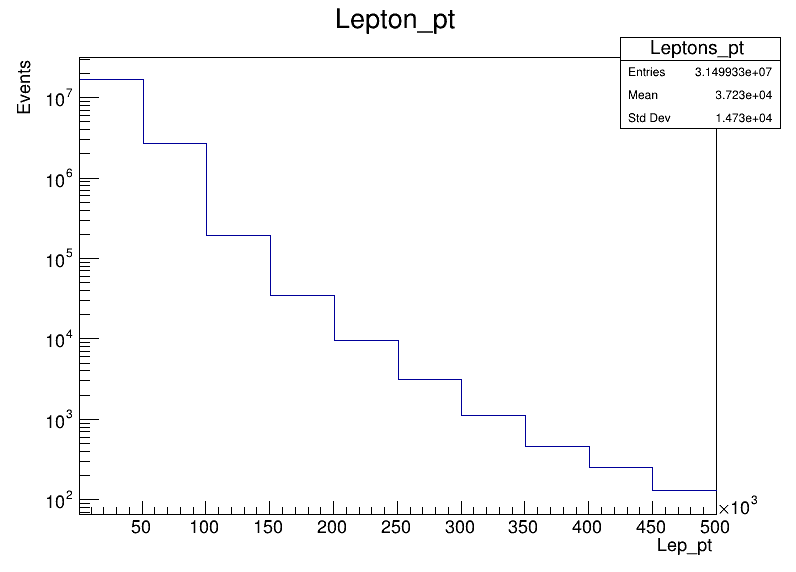

In [13]:
hist_lep_pt->Draw("");
canvas->SetLogy();
canvas->Draw();

In [90]:
cutflow -> Draw("");
canvas -> SetLogy();
canvas -> SaveAs("cutflow.jpg");

hist_lep_pt -> Draw("");
canvas -> SetLogy();
canvas -> SaveAs("lep_pt.jpg");

hist_lep_ptcone30 -> Draw("");
canvas -> SetLogy();
canvas -> SaveAs("lep_ptcone30.jpg");

hist_lep_etcone20 -> Draw("");
canvas -> SetLogy();
canvas -> SaveAs("lep_etcone20.jpg");

hist_lep_eta -> Draw("");
canvas -> SetLogy();
canvas -> SaveAs("lep_eta.jpg");

hist_jets_pt -> Draw("");
canvas -> SetLogy();
canvas -> SaveAs("jets_pt.jpg");

hist_jets_eta -> Draw("");
canvas -> SetLogy();
canvas -> SaveAs("jets_eta.jpg");

hist_jets_JVF -> Draw("");
canvas -> SetLogy();
canvas -> SaveAs("jets_JVF.jpg");

hist_jets_MV1 -> Draw("");
canvas -> SetLogy();
canvas -> SaveAs("jets_MV1.jpg");

hist_bjets_n -> Draw("");
canvas -> SetLogy();
canvas -> SaveAs("bjets_n.jpg");

hist_MET -> Draw("");
canvas -> SetLogy();
canvas -> SaveAs("MET.jpg");

hist_MTW -> Draw("");
canvas -> SetLogy();
canvas -> SaveAs("MTW.jpg");

Info in <TCanvas::Print>: jpg file cutflow.jpg has been created
Info in <TCanvas::Print>: jpg file lep_pt.jpg has been created
Info in <TCanvas::Print>: jpg file lep_ptcone30.jpg has been created
Info in <TCanvas::Print>: jpg file lep_etcone20.jpg has been created
Info in <TCanvas::Print>: jpg file lep_eta.jpg has been created
Info in <TCanvas::Print>: jpg file jets_pt.jpg has been created
Info in <TCanvas::Print>: jpg file jets_eta.jpg has been created
Info in <TCanvas::Print>: jpg file jets_JVF.jpg has been created
Info in <TCanvas::Print>: jpg file jets_MV1.jpg has been created
Info in <TCanvas::Print>: jpg file bjets_n.jpg has been created
Info in <TCanvas::Print>: jpg file MET.jpg has been created
Info in <TCanvas::Print>: jpg file MTW.jpg has been created


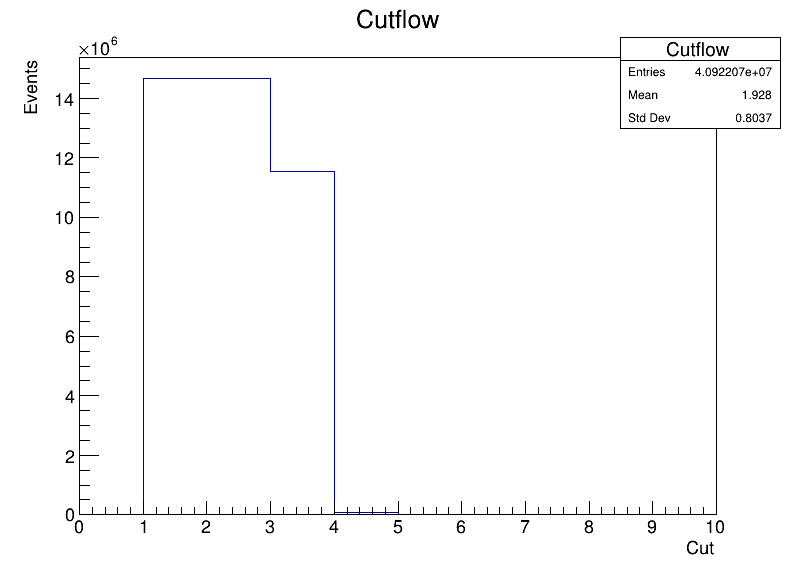

In [17]:
cutflow->Draw("");
canvas->Draw();


In [24]:
hist_njets->Draw();
//canvas->Draw();
canvas->SaveAs("n-jets.jpg");

Info in <TCanvas::Print>: jpg file n-jets.jpg has been created


# Montecarlo Comparison

In [92]:
TFile *file = TFile::Open("ttbar_8TeV.root"); 

In [93]:
TTree *treeMC = (TTree*) file->Get("mini");
treeMC->Print()

******************************************************************************
*Tree    :mini      : 4-vectors + variables required for scaling factors     *
*Entries :  1500000 : Total =       567791759 bytes  File  Size =  300057248 *
*        :          : Tree compression factor =   1.89                       *
******************************************************************************
*Br    0 :runNumber : runNumber/I                                            *
*Entries :  1500000 : Total  Size=    6002049 bytes  File Size  =      31136 *
*Baskets :       18 : Basket Size=     790016 bytes  Compression= 192.75     *
*............................................................................*
*Br    1 :eventNumber : eventNumber/I                                        *
*Entries :  1500000 : Total  Size=    6002093 bytes  File Size  =    3819950 *
*Baskets :       18 : Basket Size=     790016 bytes  Compression=   1.57     *
*...................................................

We first declare the scaling-factors and the MonteCarlo simulation weight.

In [94]:
Float_t scaleFactor_PILEUP;
Float_t scaleFactor_ELE;
Float_t scaleFactor_MUON;
Float_t scaleFactor_BTAG;
Float_t scaleFactor_TRIGGER;
Float_t scaleFactor_JVFSF;
Float_t scaleFactor_ZVERTEX;

Float_t mcWeight;

treeMC->SetBranchAddress("scaleFactor_PILEUP", &scaleFactor_PILEUP);
treeMC->SetBranchAddress("scaleFactor_ELE", &scaleFactor_ELE);
treeMC->SetBranchAddress("scaleFactor_MUON", &scaleFactor_MUON);
treeMC->SetBranchAddress("scaleFactor_BTAG", &scaleFactor_BTAG);
treeMC->SetBranchAddress("scaleFactor_TRIGGER", &scaleFactor_TRIGGER);
treeMC->SetBranchAddress("scaleFactor_JVFSF", &scaleFactor_JVFSF);
treeMC->SetBranchAddress("scaleFactor_ZVERTEX", &scaleFactor_ZVERTEX);

treeMC->SetBranchAddress("mcWeight", &mcWeight);


Now we declare and define all weights for the histogram re-scaling.

Then we fill the distribution histograms after the cuts

In [95]:
TH1F *cutflowAFcuts = new TH1F("Cutflow","Cutflow; Cut; Events",10,0,10);
TH1F *histAFcuts_njets = new TH1F("Number of jets","n-jets; Jet multiplicity; Events",10,0,10);
TH1F *histAFcuts_lep_pt = new TH1F("Leptons_pt","Lepton_pt; Lep_pt; Events",10,0,630000);
TH1F *histAFcuts_lep_ptcone30 = new TH1F("Leptons_ptcone30","Lepton ptcone30; Lep_ptcone30; Events",10,0,40);
TH1F *histAFcuts_lep_etcone20 = new TH1F("Leptons_etcone20","Lepton etcone20; Lep_etcone20; Events",10,-3000,40000);
TH1F *histAFcuts_lep_eta = new TH1F("Leptons_eta","Lepton eta; Lep_eta; Events",10,-4,4);
TH1F *histAFcuts_jets_pt = new TH1F("Jets_pt","Jets pt; Jets_pt; Events",10,0,230000);
TH1F *histAFcuts_jets_eta = new TH1F("Jets_eta","Jets_eta; Jets_eta; Events",10,-4,4);
TH1F *histAFcuts_jets_JVF = new TH1F("Jets_JVF","Jets_JVF; Jets JVF; Events",25,0,1.4);
TH1F *histAFcuts_jets_MV1 = new TH1F("Jets_MV1","Jets_MV1; Jets MV1; Events",10,0,1.1);
TH1F *histAFcuts_bjets_n = new TH1F("b-jets_n","b-jets_number;b-jets number; Events",20,0,10);
TH1F *histAFcuts_MET = new TH1F("MET","MET; MET; Events",20,0,600000);
TH1F *histAFcuts_MTW = new TH1F("MTW","MTW; MTW; Events",20,0,200000);

In [96]:

Bool_t e_trig;
Bool_t mu_trig;
Bool_t good_vtx;
UInt_t lep_n;
UInt_t jet_n;
Float_t MET;
Float_t MET_phi;

Float_t lep_pt[10];  
Float_t lep_eta[10];  
Float_t lep_phi[10];  
Float_t lep_E[10];  
Int_t lep_type[10];  
Float_t lep_ptcone30[10];
Float_t lep_etcone20[10];

Float_t jet_pt[10];  
Float_t jet_jvf[10];
Float_t jet_MV1[10];
Float_t jet_eta[10];

treeMC->SetBranchAddress("trigE", &e_trig);
treeMC->SetBranchAddress("trigM", &mu_trig);
treeMC->SetBranchAddress("hasGoodVertex", &good_vtx);
treeMC->SetBranchAddress("lep_n", &lep_n);
treeMC->SetBranchAddress("jet_n", &jet_n);
treeMC->SetBranchAddress("met_et", &MET);
treeMC->SetBranchAddress("met_phi", &MET_phi);

treeMC->SetBranchAddress("lep_pt", &lep_pt);
treeMC->SetBranchAddress("lep_eta", &lep_eta);
treeMC->SetBranchAddress("lep_phi", &lep_phi);
treeMC->SetBranchAddress("lep_E", &lep_E);
treeMC->SetBranchAddress("lep_type", &lep_type);
treeMC->SetBranchAddress("lep_ptcone30", &lep_ptcone30);
treeMC->SetBranchAddress("lep_etcone20", &lep_etcone20);

treeMC->SetBranchAddress("jet_pt", &jet_pt);
treeMC->SetBranchAddress("jet_jvf",&jet_jvf);
treeMC->SetBranchAddress("jet_MV1",&jet_MV1);
treeMC->SetBranchAddress("jet_eta", &jet_eta);



In [97]:
int nentries, nbytes, i;
nentries = (Int_t)treeMC->GetEntries();

int cut1 = 0;
int cut2 = 0;
int cut3 = 0;
int cut4 = 0;
int cut5 = 0;
int cut6 = 0;
int cut7 = 0;
int cut8 = 0;

for (i = 0; i < nentries; i++)
{
    
    nbytes = treeMC->GetEntry(i);   
    Float_t evtw = mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_BTAG*scaleFactor_TRIGGER*scaleFactor_JVFSF*scaleFactor_ZVERTEX;

    //First cut: Good vertex
    if(!good_vtx) continue;
    cut1++;
    cutflowAFcuts->Fill(1);

    //Second cut: Trigger
    if(!e_trig && !mu_trig) continue;
    cut2++;
    cutflowAFcuts->Fill(2);
    
    // Preselection of good leptons                                                                                
    int n_mu=0;
    int n_el=0;
    int n_lep=0;
    int good_lep=0;
    //Loop over leptons
    for(unsigned int i=0; i<lep_n; i++){
        if( lep_pt[i] < 25000.) continue; 
        if( lep_ptcone30[i]/lep_pt[i] > 0.15 ) continue; 
        if( lep_etcone20[i]/lep_pt[i] > 0.15 ) continue;  
        if( lep_type [i]==13 && TMath::Abs(lep_eta[i]) < 2.5 ){
            n_mu++;
             //AÑADIDO    
        }
        /*
        To complete: Add electrons and extract the index for the good lepton
        */
        if( lep_type [i]==11 && TMath::Abs(lep_eta[i]) < 2.47 ){
            if(TMath::Abs(lep_eta[i]) < 1.37 || TMath::Abs(lep_eta[i]) > 1.52){
                n_el++;
                good_lep=i;}
        }
    }
    //Select events with only 1 good lepton and fill the cutflow histogram 
    //Example:
    //Third cut (one good lepton):
    n_lep=n_el+n_mu;
    if(n_lep!=1) continue;
    cutflowAFcuts->Fill(3); 
    cut3++;
  
    
    int n_jets=0;
    int n_bjets=0;

    //Fourth cut: At least 4 jets
    if(jet_n<4) continue; 
    cutflowAFcuts->Fill(4); 
    cut4++;

    for(unsigned int j=0; j<jet_n; j++){
        // To complete: apply jet cuts to find the good jets
        if(jet_pt[j] < 25000.) continue;
        //Eta cut
        if(TMath::Abs(jet_eta[j])>2.5) continue;//Discrepancia, preguntar por que funciona con >
        // JVF cleaning 
        if(jet_jvf[j]<0.5 && TMath::Abs(jet_eta[j])< 2.4 && jet_pt[j]<50000.) continue;
        n_jets++;
        // cut on 0.7892 MV1 and count the number of b-jets
        if(jet_MV1[j]<0.7892) continue; // Las diapos dicen que debe ser >=
        n_bjets++;
        }
    
    //Fifth cut: At least 4 good jets
    if(n_jets<4) continue; 
    cutflowAFcuts->Fill(5); 
    cut5++;
    
    //Sixth cut: at least one b-jet
    if(n_bjets < 1) continue;
    cutflowAFcuts->Fill(6);
    cut6++;
    
    //Seventh cut: MET > 30 GeV
    if(MET < 30000.) continue;// Ponemos el MET > a 30000
    cutflowAFcuts->Fill(7);
    cut7++;
    // TLorentzVector definitions                                                               
    TLorentzVector Lepton  = TLorentzVector();
    TLorentzVector  MeT  = TLorentzVector();

    //To complete: Lorentz vectors for the lepton and MET. Use SetPtEtaPhiE().
    Lepton.SetPtEtaPhiE(lep_pt[good_lep],lep_eta[good_lep],lep_phi[good_lep],lep_E[good_lep]);
    MeT.SetPtEtaPhiE(MET,0,MET_phi,MET); 
    //Calculation of the mTW using TLorentz vectors             
    float mTW = sqrt(2*Lepton.Pt()*MeT.Et()*(1-cos(Lepton.DeltaPhi(MeT))));

    //Eight cut: mTW > 30 GeV
    if(mTW<30000.) continue;
    cutflowAFcuts->Fill(8);    
    cut8++;
    
    //We fill all histograms after cuts for MC 

    for(unsigned int i=0; i<lep_n; i++){
        histAFcuts_lep_pt->Fill(lep_pt[i],evtw);
        histAFcuts_lep_ptcone30->Fill(lep_ptcone30[i]/lep_pt[i],evtw);
        histAFcuts_lep_etcone20->Fill(lep_etcone20[i]/lep_pt[i],evtw);
        histAFcuts_lep_eta->Fill(lep_eta[i],evtw);
    }


    for(unsigned int k=0; k<jet_n; k++){
        histAFcuts_jets_pt->Fill(jet_pt[k],evtw);
        histAFcuts_jets_eta->Fill(jet_eta[k],evtw);
        histAFcuts_jets_JVF->Fill(jet_jvf[k],evtw);
        histAFcuts_jets_MV1->Fill(jet_MV1[k],evtw);
    }
    histAFcuts_njets->Fill(jet_n,evtw);
    histAFcuts_bjets_n->Fill(n_bjets,evtw);
    histAFcuts_MTW->Fill(mTW,evtw);
    histAFcuts_MET->Fill(MET,evtw);
    //histAFcuts_MET->Fill(MET,mcWeight);
}

std::cout << "Done!" << std::endl;
std::cout << "All events:" << nentries << std::endl;
std::cout << "Cut1:" << cut1 << std::endl;
std::cout << "Cut2:" << cut2 << std::endl;
std::cout << "Cut3:" << cut3 << std::endl;
std::cout << "Cut4:" << cut4 << std::endl;
std::cout << "Cut5:" << cut5 << std::endl;
std::cout << "Cut6:" << cut6 << std::endl;
std::cout << "Cut7:" << cut7 << std::endl;
std::cout << "Cut8:" << cut8 << std::endl;



Done!
All events:-1084358092
Cut1:912253
Cut2:912253
Cut3:812811
Cut4:379900
Cut5:379153
Cut6:326367
Cut7:270576
Cut8:227768


In [98]:
TCanvas *canvas2 = new TCanvas("CanvasComp","",800,600);

Warning in <TCanvas::Constructor>: Deleting canvas with same name: CanvasComp


In [31]:
cutflow->SetLineColor(kRed);
cutflow->Draw("");
cutflowAFcuts->Draw("same");
canvas2->SetLogy();
canvas2->SaveAs("comp_cutflow.jpg");

hist_lep_pt->SetLineColor(kRed);
hist_lep_pt->Draw("");
histAFcuts_lep_pt->Draw("same");
canvas2->SetLogy();
//canvas2->Draw()
canvas2->SaveAs("complep_pt.jpg");

hist_lep_ptcone30->SetLineColor(kRed);
hist_lep_ptcone30->Draw("");
histAFcuts_lep_ptcone30->Draw("same");
canvas2 -> SetLogy();
//canvas2->Draw()
canvas2 -> SaveAs("complep_ptcone30.jpg");

hist_lep_etcone20->SetLineColor(kRed);
hist_lep_etcone20 -> Draw("");
histAFcuts_lep_etcone20-> Draw("same");
canvas2 -> SetLogy();
//canvas2->Draw()
canvas2 -> SaveAs("complep_etcone20.jpg");

hist_lep_eta->SetLineColor(kRed);
hist_lep_eta -> Draw("");
histAFcuts_lep_eta-> Draw("same");
canvas2 -> SetLogy();
//canvas2->Draw()
canvas2 -> SaveAs("complep_eta.jpg");

hist_jets_pt->SetLineColor(kRed);
hist_jets_pt -> Draw("");
histAFcuts_jets_pt-> Draw("same");
canvas2 -> SetLogy();
//canvas2->Draw()
canvas2 -> SaveAs("compjets_pt.jpg");

hist_jets_eta->SetLineColor(kRed);
hist_jets_eta -> Draw("");
histAFcuts_jets_eta-> Draw("same");
canvas2 -> SetLogy();
//canvas2->Draw()
canvas2 -> SaveAs("compjets_eta.jpg");

hist_jets_JVF->SetLineColor(kRed);
hist_jets_JVF -> Draw("");
histAFcuts_jets_JVF-> Draw("same");
canvas2 -> SetLogy();
//canvas2->Draw()
canvas2 -> SaveAs("compjets_JVF.jpg");

hist_jets_MV1->SetLineColor(kRed);
hist_jets_MV1 -> Draw("");
histAFcuts_jets_MV1-> Draw("same");
canvas2 -> SetLogy();
//canvas2->Draw()
canvas2 -> SaveAs("compjets_MV1.jpg");

hist_bjets_n->SetLineColor(kRed);
hist_bjets_n -> Draw("");
histAFcuts_bjets_n-> Draw("same");
canvas2 -> SetLogy();
//canvas2->Draw()
canvas2 -> SaveAs("compbjets_n.jpg");

hist_MET->SetLineColor(kRed);
hist_MET -> Draw("");
histAFcuts_MET-> Draw("same");
canvas2 -> SetLogy();
//canvas2->Draw()
canvas2 -> SaveAs("compMET.jpg");

hist_MTW->SetLineColor(kRed);
hist_MTW -> Draw("");
histAFcuts_MTW-> Draw("same");
canvas2 -> SetLogy();
//canvas2->Draw()
canvas2 -> SaveAs("compMTW.jpg");

hist_njets->SetLineColor(kRed);
hist_njets->Draw();
histAFcuts_njets-> Draw("same");
//canvas2->Draw();
canvas2->SaveAs("compn-jets.jpg");

Info in <TCanvas::Print>: jpg file comp_cutflow.jpg has been created
Info in <TCanvas::Print>: jpg file complep_pt.jpg has been created
Info in <TCanvas::Print>: jpg file complep_ptcone30.jpg has been created
Info in <TCanvas::Print>: jpg file complep_etcone20.jpg has been created
Info in <TCanvas::Print>: jpg file complep_eta.jpg has been created
Info in <TCanvas::Print>: jpg file compjets_pt.jpg has been created
Info in <TCanvas::Print>: jpg file compjets_eta.jpg has been created
Info in <TCanvas::Print>: jpg file compjets_JVF.jpg has been created
Info in <TCanvas::Print>: jpg file compjets_MV1.jpg has been created
Info in <TCanvas::Print>: jpg file compbjets_n.jpg has been created
Info in <TCanvas::Print>: jpg file compMET.jpg has been created
Info in <TCanvas::Print>: jpg file compMTW.jpg has been created
Info in <TCanvas::Print>: jpg file compn-jets.jpg has been created


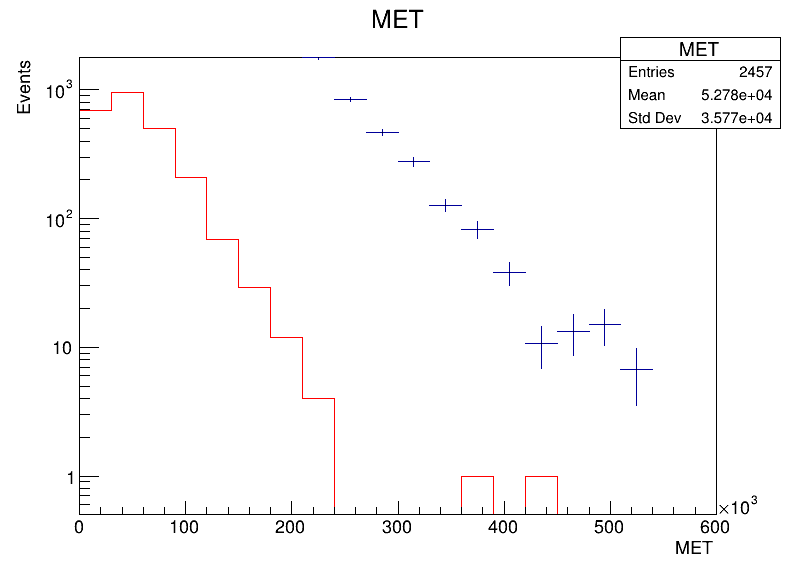

In [99]:
hist_MET->SetLineColor(kRed);
hist_MET -> Draw("");
histAFcuts_MET-> Draw("same");
canvas2 -> SetLogy();
canvas2->Draw();
//canvas2 -> SaveAs("compMET.jpg");